## Tensorflow

In [208]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
from sklearn.externals import joblib 
import os

%matplotlib inline
np.random.seed(1)

In [209]:
tf.__version__

'1.10.0'

Writing and running programs in TensorFlow has the following steps:

   1) Create Tensors (variables) that are not yet executed/evaluated. <br>
   2) Write operations between those Tensors. <br>
   3) Initialize your Tensors. <br>
   4) Create a Session. <br>
   5) Run the Session. This will run the operations you'd written above.


### Some basic examples

In [8]:
y_hat = tf.constant(36, name='y_hat')
y = tf.constant(30, name='y')

loss = tf.Variable((y_hat - y)**2, name='loss')

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(loss))

36


In [53]:
x = tf.placeholder(tf.float32)
W = tf.constant(3.3)
b = tf.constant(0.78)

z = tf.add(tf.multiply(x,W), b)

with tf.Session() as sess:
    print(sess.run(z, feed_dict={x : 7.1}))

24.21


In [64]:
def linear_function(x):
    
    W = np.random.randn(5, 2) * 0.01
    b = np.random.randn(5, 1)
    
    z = tf.add(tf.matmul(W, x), b)
    
    with tf.Session() as sess:
        z = sess.run(z)
        
    return z
    

In [65]:
x = np.array([[3, 1],[7, 5]], dtype=np.float64)
z = linear_function(x)
print(z)

[[-0.39820008 -0.42588157]
 [ 1.16853803  1.18881833]
 [ 0.42161028  0.41159359]
 [ 0.58631469  0.59231983]
 [-1.06464963 -1.06621025]]


### Computing sigmoid

In [67]:
def sigmoid(z):
    
    place_holder = tf.placeholder(tf.float32, name='place_holder')
    sigmoid = tf.divide(1, (1 + tf.exp(-place_holder)))    # Or can call the function tf.sigmoid()
    
    with tf.Session() as sess:
        result = sess.run(sigmoid, feed_dict={place_holder : z})
        
    return result

In [68]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

sigmoid(0) = 0.5
sigmoid(12) = 0.9999938


### Computing Loss

using tf.nn.sigmoid_cross_entropy_with_logits

In [81]:
def compute_cost(logits, labels):
    """
    Computes the cost using the sigmoid cross entropy
    
    Arguments:
    logits -- vector containing z, output of the last linear unit (before the final sigmoid activation)
    labels -- vector of labels y (1 or 0) 
    
    Note: What we've been calling "z" and "y" in this class are respectively called "logits" and "labels" 
    in the TensorFlow documentation. So logits will feed into z, and labels into y. 
    
    Returns:
    cost -- runs the session of the cost (formula (2))
    """
    
    z = tf.placeholder(tf.float32, name='logits')
    y = tf.placeholder(tf.float32, name='labels')
    
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=z)
    
    with tf.Session() as sess:
        result = sess.run(loss, feed_dict={z: logits, y: labels})
        
    return result

In [83]:
logits = sigmoid(np.array([0.2, 0.4, 0.7, 0.9]))
cost = compute_cost(logits, np.array([0, 0, 1, 1]))
print ("cost = " + str(cost))

cost = [1.0053872  1.0366408  0.41385433 0.39956617]


### Using One-hot encodings

Using tf.one_hot(indices=matrix_to_be_encoded, depth='no_of_digits_per_element_in_input_matrix', axis=0 or 1)

In [111]:
def one_hot_encoder(labels, C, axis):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. Each column represent a label if axis=0, each row will represent a label if axis=1
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    C = tf.constant(C, tf.int32)
    label_matrix = tf.placeholder(tf.int32)
    
    one_hot_encode = tf.one_hot(indices=label_matrix, depth=C, axis=axis)
    
    with tf.Session() as sess:
        one_hot_encoded_op = sess.run(one_hot_encode, feed_dict = {label_matrix : labels})
        
    return one_hot_encoded_op
        
    

In [112]:
labels = np.array([1,2,3,0,2,1])

one_hot_along_axis0 = one_hot_encoder(labels, C=4, axis=0)
print ("Along axis=0 each column represents a label\n" + str(one_hot_along_axis0))
print("It's shape: " + str(one_hot_along_axis0.shape))

one_hot_along_axis1 = one_hot_encoder(labels, C=4, axis=1)
print ("Along axis=1 each row represents a label\n" + str(one_hot_along_axis1))
print("It's shape: " + str(one_hot_along_axis1.shape))

Along axis=0 each column represents a label
[[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]]
It's shape: (4, 6)
Along axis=1 each row represents a label
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
It's shape: (6, 4)


### Builing a Model to recognize the number represented by hand signs

In [105]:
# Loading the dataset
X_train_orig, y_train_orig, X_test_orig, y_test_orig, classes = load_dataset()
print(X_train_orig.shape)
print(y_train_orig.shape)
print(X_test_orig.shape)
print(y_test_orig.shape)

print("Number of train examples: " + str(y_train_orig.shape[1]))
print("Number of test examples: " + str(y_test_orig.shape[1]))

(1080, 64, 64, 3)
(1, 1080)
(120, 64, 64, 3)
(1, 120)
Number of train examples: 1080
Number of test examples: 120


y = 5


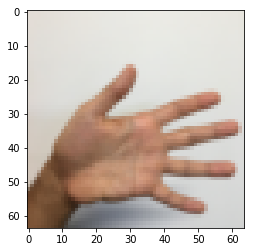

In [100]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [131]:
# Preprocess the data

num_classes = classes.shape[0]

X_train = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test = X_test_orig.reshape(X_test_orig.shape[0], -1).T

X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# Reshape to convert (n_classes, 1, n_examples) to (n_classes, n_examples)
y_train = one_hot_encoder(y_train_orig, num_classes, axis=0).reshape(y_train.shape[0],-1) 
y_test = one_hot_encoder(y_test_orig, num_classes, axis=0).reshape(y_train.shape[0],-1)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(12288, 1080) (12288, 120)
(6, 1080) (6, 120)


In [134]:
# Create placeholders for X and y

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """
    
    X = tf.placeholder(tf.float32, shape=(n_x, None), name='X')
    y = tf.placeholder(tf.float32, shape=(n_y, None), name='y')
    
    return X, y

In [135]:
X, Y = create_placeholders(12288, 6)
print("X = " + str(X))
print("Y = " + str(Y))

X = Tensor("X_16:0", shape=(12288, ?), dtype=float32)
Y = Tensor("y_4:0", shape=(6, ?), dtype=float32)


In [138]:
# Initialize the parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    Wi = tf.get_variable("Wi", (nl,nl-1), initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    bi = tf.get_variable("bi", (nl,1), initializer = tf.zeros_initializer())
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    W1 = tf.get_variable("W1", (25, 12288), initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", (25, 1), initializer=tf.zeros_initializer())
    
    W2 = tf.get_variable("W2", (12, 25), initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", (12, 1), initializer=tf.zeros_initializer())
    
    W3 = tf.get_variable("W3", (6, 12), initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", (6, 1), initializer=tf.zeros_initializer())
    
    parameters = {
        "W1" : W1,
        "b1" : b1,
        "W2" : W2,
        "b2" : b2,
        "W3" : W3,
        "b3" : b3
    }
    
    return parameters

In [140]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print("W3 = " + str(parameters["W3"]))
    print("b3 = " + str(parameters["b3"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(6, 12) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(6, 1) dtype=float32_ref>


### Forward propagation

In [141]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3

In [142]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, ?), dtype=float32)


### Compute Cost

In [191]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [192]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


### Define the Model

In [197]:
def model(X_train, y_train, X_test, y_test, alpha = 0.0001, num_epochs = 1500, 
          minibatch_size = 32, verbose = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    y_test -- test set, of shape (output size = 6, number of test examples = 120)
    alpha -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    verbose -- True to print the cost every 5 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph() # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)
    seed = 3
    
    costs = []
    n_x, m = X_train.shape
    n_y = y_train.shape[0]
    
    X, y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X=X, parameters=parameters)
    
    cost = compute_cost(Z3, y)
    
    #####################################BACKPROP#########################
    optimizer = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost)
    ######################################################################
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            epoch_cost = 0.
            t = int(m / minibatch_size) # t - total number of minibatches
            seed = seed + 1
            minibatches = random_mini_batches(X_train, y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                
                minibatch_X, minibatch_y = minibatch
                minibatch_cost = sess.run(cost, feed_dict={X : minibatch_X, 
                                                           y : minibatch_y})
                _ = sess.run(optimizer, feed_dict={X : minibatch_X, 
                                                   y : minibatch_y})
                epoch_cost += minibatch_cost / t
                
            if verbose == True and epoch % 50 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
             
            if verbose == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(alpha))
        plt.show()
        
        # Update the parameters at the end of training
        parameters = sess.run(parameters)
        print("Weights have been trained!")
        
        # Predictions
        correct_predictions = tf.equal(tf.argmax(Z3), tf.argmax(y))
        
        # Accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, dtype='float'))
        
        # Compute train and test accuracy
        train_acc = sess.run(accuracy, feed_dict={X : X_train,
                                                  y : y_train})
        test_acc = sess.run(accuracy, feed_dict={X : X_test,
                                                 y : y_test})
        
        print("Train accuracy: " + str(train_acc))
        print("Test accuracy: " + str(test_acc))
        
        return parameters     
               
    

Cost after epoch 0: 1.856599
Cost after epoch 50: 1.483496
Cost after epoch 100: 1.030758
Cost after epoch 150: 0.861951
Cost after epoch 200: 0.732693
Cost after epoch 250: 0.635604
Cost after epoch 300: 0.575480
Cost after epoch 350: 0.536521
Cost after epoch 400: 0.464848
Cost after epoch 450: 0.415730
Cost after epoch 500: 0.375019
Cost after epoch 550: 0.341738
Cost after epoch 600: 0.314070
Cost after epoch 650: 0.282846
Cost after epoch 700: 0.244342
Cost after epoch 750: 0.219799
Cost after epoch 800: 0.197800
Cost after epoch 850: 0.183882
Cost after epoch 900: 0.161732
Cost after epoch 950: 0.139801
Cost after epoch 1000: 0.136123
Cost after epoch 1050: 0.118002
Cost after epoch 1100: 0.101406
Cost after epoch 1150: 0.086815
Cost after epoch 1200: 0.086436
Cost after epoch 1250: 0.066010
Cost after epoch 1300: 0.055728
Cost after epoch 1350: 0.049874
Cost after epoch 1400: 0.048634
Cost after epoch 1450: 0.037441


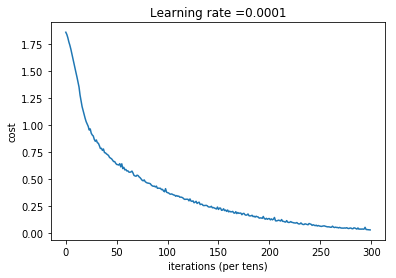

Weights have been trained!
Train accuracy: 0.9990741
Test accuracy: 0.7583333


In [198]:
parameters = model(X_train, y_train, X_test, y_test)

In [213]:
def save_weights(parameters, filename="weights.pkl"):
    
    file = os.path.join(os.getcwd(), filename)
    joblib.dump(parameters, file)

In [214]:
save_weights(parameters)

##############To load the parameters###############################
#load_parms = joblib.load(os.path.join(os.getcwd(),'weights.pkl'))#
###################################################################